### Setup

In [2]:
from __future__ import print_function
import random
import numpy as np
import time
from utils.data_utils import load_CIFAR10, get_CIFAR10_data
from utils.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from utils.solver import Solver
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [3]:
# let's download the data
%cd ../datasets

# 1 -- Linux 
# 2 -- MacOS
# 3 -- Command Prompt on Windows
# 4 -- manually downloading the data
choice = 3


if choice == 1:
    # should work well on Linux and in Powershell on Windows
    !wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
elif choice == 2 or choice ==3:
    # if wget is not available for you, try curl
    # should work well on MacOS
    !curl http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz --output cifar-10-python.tar.gz
else:
    print('Please manually download the data from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and put it under the datasets folder.')
!tar -xzvf cifar-10-python.tar.gz

if choice==3:
    !del cifar-10-python.tar.gz
else:
    !rm cifar-10-python.tar.gz

D:\CS7150\pa1\datasets


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 10  162M   10 16.7M    0     0  20.7M      0  0:00:07 --:--:--  0:00:07 20.7M
 35  162M   35 58.3M    0     0  32.1M      0  0:00:05  0:00:01  0:00:04 32.1M
 67  162M   67  110M    0     0  39.2M      0  0:00:04  0:00:02  0:00:02 39.2M
 98  162M   98  160M    0     0  42.1M      0  0:00:03  0:00:03 --:--:-- 42.1M
100  162M  100  162M    0     0  42.3M      0  0:00:03  0:00:03 --:--:-- 42.3M
x cifar-10-batches-py/
x cifar-10-batches-py/data_batch_4
x cifar-10-batches-py/readme.html
x cifar-10-batches-py/test_batch
x cifar-10-batches-py/data_batch_3
x cifar-10-batches-py/batches.meta
x cifar-10-batches-py/data_batch_2
x cifar-10-batches-py/data_batch_5
x cifar-10-batches-py/data_batch_1


In [4]:
# Load the raw CIFAR-10 data.
cifar10_dir = '../datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


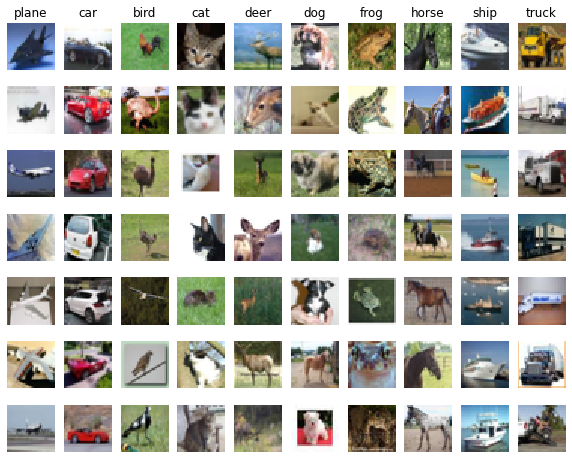

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# Split the data into train, val, and test sets. 
# Check the get_CIFAR10_data function for more details
data = get_CIFAR10_data(cifar10_dir)
for k, v in list(data.items()):
    print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


## Convolutional Neural Network

### Convolution layers

<font size="4" color="red">**forward pass of a convolution layer with 2 for loops**

In [30]:
def conv_forward_naive(x, w, b, conv_param):
    """
    A naive implementation of the forward pass for a convolutional layer.

    The input consists of N data points, each with C channels, height H and
    width W. We convolve each input with F different filters, where each filter
    spans all C channels and has height HH and width WW.

    Input:
    - x: Input data of shape (N, C, H, W)
    - w: Filter weights of shape (F, C, HH, WW)
    - b: Biases, of shape (F,)
    - conv_param: A dictionary with the following keys:
      - 'stride': The number of pixels between adjacent receptive fields in the
        horizontal and vertical directions.
      - 'pad': The number of pixels that will be used to zero-pad the input.


    During padding, 'pad' zeros should be placed symmetrically (i.e equally on both sides)
    along the height and width axes of the input. Be careful not to modfiy the original
    input x directly.

    Returns a tuple of:
    - out: Output data, of shape (N, F, H', W') where H' and W' are given by
      H' = 1 + (H + 2 * pad - HH) / stride
      W' = 1 + (W + 2 * pad - WW) / stride
    - cache: (x, w, b, conv_param)
    """
    out = None
    
    ###########################################################################
    # TODO: Implement the convolutional forward pass.                         #
    # Hint: you can use the function np.pad for padding.                      #
    ###########################################################################
    
    #given
    numOfImages = x.shape[0]
    channels = x.shape[1]
    image_height = x.shape[2]
    image_width = x.shape[3]
    numOfFilters = w.shape[0]
    filter_height = w.shape[2]
    filter_width = w.shape[3]
    Hout = 1 + (image_height + 2 * conv_param['pad'] - filter_height) / conv_param['stride']
    Wout = 1 + (image_width + 2 * conv_param['pad'] - filter_width) / conv_param['stride']
    
    #initializing output
    out = np.empty((numOfImages, numOfFilters, int(Hout), int(Wout)))
    Hout = int(Hout)
    Wout = int(Wout)
    
    #padding
    pad_dim = ((0,0),(0,0),(conv_param['pad'],conv_param['pad']),(conv_param['pad'],conv_param['pad']))
    padded_img = np.pad(x, pad_width = pad_dim)
    
    #reshape W
    secondDim = channels * filter_height * filter_width
    wReshape = np.transpose(w.reshape(numOfFilters,secondDim))
  
    for height in range(Hout):
        for width in range(Wout):
            startH = height * conv_param['stride']
            stopH = (height * conv_param['stride']) + filter_height
            startW = width * conv_param['stride']
            stopW = (width * conv_param['stride']) + filter_width
            imageSec = padded_img[:,:,startH:stopH, startW:stopW]
            imageReshapeSec = imageSec.reshape(numOfImages, secondDim)
            out[:,:,height,width] = np.dot(imageReshapeSec, wReshape) + b
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    cache = (x, w, b, conv_param)
    return out, cache

<font size="4" color="red">**backward pass of a convolution layer with 2 for loops**

In [32]:
def conv_backward_naive(dout, cache):
    """
    A naive implementation of the backward pass for a convolutional layer.

    Inputs:
    - dout: Upstream derivatives.
    - cache: A tuple of (x, w, b, conv_param) as in conv_forward_naive

    Returns a tuple of:
    - dx: Gradient with respect to x
    - dw: Gradient with respect to w
    - db: Gradient with respect to b
    """
    dx, dw, db = None, None, None
    
    ###########################################################################
    # TODO: Implement the convolutional backward pass.                        #
    ###########################################################################

    #start = time.time()
    (x, w, b, conv_param) = cache
    #given
    numOfImages = x.shape[0]
    channels = x.shape[1]
    image_height = x.shape[2]
    image_width = x.shape[3]
    numOfFilters = w.shape[0]
    filter_height = w.shape[2]
    filter_width = w.shape[3]
    outputNum = out.shape[0]
    Hout = 1 + (image_height + 2 * conv_param['pad'] - filter_height) / conv_param['stride']
    Wout = 1 + (image_width + 2 * conv_param['pad'] - filter_width) / conv_param['stride']
    Hout = int(Hout)
    Wout = int(Wout)
    #reshape W
    secondDim = channels * filter_height * filter_width
    wReshape = np.transpose(w.reshape(numOfFilters,secondDim))
    
    #initializing dx, dw, dX(to be unpadded) & db
    #padded dx
    dX = np.zeros((numOfImages, channels, image_height + (2 * conv_param['pad']), image_width + (2 * conv_param['pad'])))
    dw = np.zeros_like(w)
    db = np.zeros_like(b)

    #padding x
    pad_dim = ((0,0),(0,0),(conv_param['pad'],conv_param['pad']),(conv_param['pad'],conv_param['pad']))
    padded_img = np.pad(x, pad_width = pad_dim)

    #updating gradients
    for height in range(Hout):
        for width in range(Wout):
            startH = height * conv_param['stride']
            stopH = (height * conv_param['stride']) + filter_height
            startW = width * conv_param['stride']
            stopW = (width * conv_param['stride']) + filter_width
            imageSec = padded_img[:, :,startH:stopH,startW:stopW]
            dXsec = dX[:, :,startH:stopH,startW:stopW]
            dX[:,:,startH:stopH,startW:stopW] += np.matmul(dout[:,:,height,width],np.transpose(wReshape)).reshape(dXsec.shape)
            dw[:] += np.transpose(np.dot((np.transpose(imageSec.reshape((imageSec.shape[0],-1)))),(dout[:,:,height,width]))).reshape((w.shape))

    unpaddedIndexHstart = conv_param['pad']
    unpaddedIndexHstop =  conv_param['pad'] + image_height
    unpaddedIndexWstart = conv_param['pad']
    unpaddedIndexWstop =  conv_param['pad'] + image_width
    dx = dX[:, :,unpaddedIndexHstart:unpaddedIndexHstop, unpaddedIndexWstart:unpaddedIndexWstop]
    #sum of all convolutions
    db = np.sum(dout,axis = (0,2,3))
    #print(time.time() - start)
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    return dx, dw, db

### Spatial Batch Normalization


<font size='4' color='red'>**forward pass of a (normal) batch norm layer.**

In [34]:
def batchnorm_forward(x, gamma, beta, bn_param):
    """
    Forward pass for batch normalization.

    During training the sample mean and (uncorrected) sample variance are
    computed from minibatch statistics and used to normalize the incoming data.
    During training we also keep an exponentially decaying running mean of the
    mean and variance of each feature, and these averages are used to normalize
    data at test-time.

    At each timestep we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var

    Note that the batch normalization paper suggests a different test-time
    behavior: they compute sample mean and variance for each feature using a
    large number of training images rather than using a running average. For
    this implementation we have chosen to use running averages instead since
    they do not require an additional estimation step; the torch7
    implementation of batch normalization also uses running averages.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)

    N, D = x.shape

    running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))
    
    out, cache = None, None
    if mode == 'train':
        #######################################################################
        # TODO: Implement the training-time forward pass for batch norm.      #
        # Use minibatch statistics to compute the mean and variance, use      #
        # these statistics to normalize the incoming data, and scale and      #
        # shift the normalized data using gamma and beta.                     #
        #                                                                     #
        # You should store the output in the variable out. Any intermediates  #
        # that you need for the backward pass should be stored in the cache   #
        # variable.                                                           #
        #                                                                     #
        # You should also use your computed sample mean and variance together #
        # with the momentum variable to update the running mean and running   #
        # variance, storing your result in the running_mean and running_var   #
        # variables.                                                          #
        #                                                                     #
        # Note that though you should be keeping track of the running         #
        # variance, you should normalize the data based on the standard       #
        # deviation (square root of variance) instead!                        #
        # Referencing the original paper (https://arxiv.org/abs/1502.03167)   #
        # might prove to be helpful.                                          #
        #######################################################################
        
        mu = 1./N * np.sum(x, axis=0)
        xmu = x - mu
        summationTerm = xmu ** 2
        sigmaSq = 1./N * np.sum(summationTerm, axis=0)
        
        stableVar = np.sqrt(sigmaSq + eps)
        invertedStableVar = 1./stableVar
        normalizedX = (x - mu) * invertedStableVar
        GammaX = gamma * normalizedX
        out = GammaX + beta

        running_mean = momentum * running_mean + (1 - momentum) * mu
        running_var = momentum * running_var + (1 - momentum) * sigmaSq
        
        cache = (normalizedX, gamma, xmu, invertedStableVar, stableVar, sigmaSq, eps)
        
        #######################################################################
        #                           END OF YOUR CODE                          #
        #######################################################################
    elif mode == 'test':
        #######################################################################
        # TODO: Implement the test-time forward pass for batch normalization. #
        # Use the running mean and variance to normalize the incoming data,   #
        # then scale and shift the normalized data using gamma and beta.      #
        # Store the result in the out variable.                               #
        #######################################################################
        
        mu = running_mean
        sigmaSq = running_var
        
        stableVar = np.sqrt(sigmaSq + eps)
        invertedStableVar = 1./stableVar
        normalizedX = (x - mu) * invertedStableVar
        GammaX = gamma * normalizedX
        out = GammaX + beta
        
        cache = None

        #######################################################################
        #                          END OF YOUR CODE                           #
        #######################################################################
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param['running_mean'] = running_mean
    bn_param['running_var'] = running_var

    return out, cache

<font size='4' color='red'>**forward pass of a spatial batch norm layer.**

In [35]:
def spatial_batchnorm_forward(x, gamma, beta, bn_param):
    """
    Computes the forward pass for spatial batch normalization.

    Inputs:
    - x: Input data of shape (N, C, H, W)
    - gamma: Scale parameter, of shape (C,)
    - beta: Shift parameter, of shape (C,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance. momentum=0 means that
        old information is discarded completely at every time step, while
        momentum=1 means that new information is never incorporated. The
        default of momentum=0.9 should work well in most situations.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: Output data, of shape (N, C, H, W)
    - cache: Values needed for the backward pass
    """
    out, cache = None, None

    ###########################################################################
    # TODO: Implement the forward pass for spatial batch normalization.       #
    #                                                                         #
    # HINT: You can implement spatial batch normalization by calling the      #
    # vanilla version of batch normalization you implemented above.           #
    # Your implementation should be very short; ours is less than five lines. #
    ###########################################################################
    
    (N, C, H, W) = x.shape
    #collapsing in the right order since reshape(1,C,1,1) will give the right shape but wrong array to pass to batchnorm_fw
    modified_x = (np.transpose(x,(0,2,3,1))).reshape(-1,C)
    out_normal, cache = batchnorm_forward(modified_x, gamma, beta, bn_param)
    #reshaping to output shape
    out = np.transpose(out_normal.reshape(N, H, W, C),(0,3,1,2))

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return out, cache

<font size='4' color='red'>**backward pass of a (normal) batch norm layer.**

In [38]:
def batchnorm_backward(dout, cache):
    """
    Backward pass for batch normalization.
    
    For this implementation you should work out the derivatives for the batch
    normalizaton backward pass on paper and simplify as much as possible. You
    should be able to derive a simple expression for the backward pass.

    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None
    ###########################################################################
    # TODO: Implement the backward pass for batch normalization. Store the    #
    # results in the dx, dgamma, and dbeta variables.                         #
    #                                                                         #
    # After computing the gradient with respect to the centered inputs, you   #
    # should be able to compute gradients with respect to the inputs in a     #
    # single statement.                                                       #
    ###########################################################################
    
    (normalizedX, gamma, xmu, invertedStableVar, stableVar, sigmaSq, eps) = cache
    #retracing and differentiating the steps from forward batchnorm
    N,D = dout.shape
    dbeta = np.sum(dout, axis=0)
    dgamma = np.sum(dout*normalizedX, axis=0)
    dnX = dout * gamma
    diSV = np.sum(dnX*xmu, axis=0)
    dxmu1 = dnX * invertedStableVar
    dSV = -1./ (stableVar**2) * diSV
    dsigmaSq = 0.5 * 1. /np.sqrt(sigmaSq + eps) * dSV
    dsq = 1. /N * np.ones((N,D)) * dsigmaSq
    dxmu2 = 2 * xmu * dsq
    dx1 = (dxmu1 + dxmu2)
    dmu = -1 * np.sum(dxmu1 + dxmu2, axis=0)
    dx2 = 1. /N * np.ones((N,D)) * dmu
    dx = dx1 + dx2
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return dx, dgamma, dbeta

<font size='4' color='red'>**backward pass of a spatial batch norm layer.**

In [39]:
def spatial_batchnorm_backward(dout, cache):
    """
    Computes the backward pass for spatial batch normalization.

    Inputs:
    - dout: Upstream derivatives, of shape (N, C, H, W)
    - cache: Values from the forward pass

    Returns a tuple of:
    - dx: Gradient with respect to inputs, of shape (N, C, H, W)
    - dgamma: Gradient with respect to scale parameter, of shape (C,)
    - dbeta: Gradient with respect to shift parameter, of shape (C,)
    """
    dx, dgamma, dbeta = None, None, None

    ###########################################################################
    # TODO: Implement the backward pass for spatial batch normalization.      #
    #                                                                         #
    # HINT: You can implement spatial batch normalization by calling the      #
    # vanilla version of batch normalization you implemented above.           #
    # Your implementation should be very short; ours is less than five lines. #
    ###########################################################################
    
    (N, C, H, W) = dout.shape
    #collapsing in the right order since reshape(1,C,1,1) will give the right shape but wrong array to pass to batchnorm_fw
    modified_dout = (np.transpose(dout,(0,2,3,1))).reshape(-1,C)
    dX, dgamma, dbeta = batchnorm_backward(modified_dout, cache)
    #reshaping to output shape
    dx = np.transpose(dX.reshape(N, H, W, C),(0,3,1,2))

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return dx, dgamma, dbeta

### Global average pooling layer


<font size='4' color='red'>**forward pass of an global average pooling layer.**

In [41]:
def global_avg_pool_forward(x):
    """
    Computes the forward pass of the global average pooling layer
    
    Input:
    - x: Input data of shape (N, C, H, W)
    
    Returns of a tuple of:
    - out: Output data, of shape (N, C)
    - cache: (x,)
    """
    out, cache = None, x
    
    ###########################################################################
    # TODO: Implement the forward pass for global average pooling.            #
    ###########################################################################
    
    out = np.mean(x, axis = (2,3))

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    return out, cache

<font size='4' color='red'>**backward pass of a global average pooling layer.**

In [43]:
def global_avg_pool_backward(dout, cache):
    """
    Computes the forward pass of the global average pooling layer
    
    Inputs:
    - dout: Upstream derivatives.
    - cache: x as in global_avg_pool_backward
    
    Returns:
    - dx: gradient with respect x
    
    """
    dx = None
    
    ###########################################################################
    # TODO: Implement the backward pass for global average pooling.           #
    ###########################################################################
    
    x = cache
    N, C, H, W = x.shape
    dx = np.zeros(x.shape)
    dX = np.repeat(dout[:,:,None]/(H*W), repeats = W, axis = 2)
    dx = np.repeat(dX[:,:,:,None], repeats = H, axis = 3)       
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    return dx    

### ConvNet 


<font size='4' color='red'>**Implement a fully convolutional CNN.**

In [45]:
class ConvNet(object):
    """
    A simple fully convolutional network with the following architecture:

    [conv - bn - relu] x M - global_average_pooling - affine - softmax
    
    "[conv - bn - relu] x M" means the "conv-bn-relu" combination is repeated for
    M times, where M is implicitly defined by the convolution layers' parameters.
    
    For each convolution layer, we do downsampling of factor 2 by setting its stride
    to be 2. So we can have a large receptive field size.

    The network operates on minibatches of data that have shape (N, C, H, W)
    consisting of N images, each with height H and width W and with C input
    channels (C=3 corresponding to RGB).
    """

    def __init__(self, input_dim=(3, 32, 32), num_filters=[32], filter_sizes=[7],
            num_classes=10, weight_scale=1e-3, reg=0.0, use_batch_norm=True, 
            dtype=np.float32):
        """
        Initialize a new network.

        Inputs:
        - input_dim: Tuple (C, H, W) giving size of input data.
        - num_filters: List of number of filters to use in the convolutional layers. 
          It is a list whose length defines the number of convolution layers and each
          element defines how many convolution filters are in a convolution layer.
        - filter_sizes: Width/height of filters to use in the convolutional layers. It
          is a list with the same length with num_filters.
        - num_classes: Number of output classes.
        - weight_scale: Scalar giving standard deviation for random initialization
          of weights.
        - reg: Scalar giving L2 regularization strength.
        - use_batch_norm: A boolean variable indicating whether to use batch normalization
        - dtype: numpy datatype to use for computation.
        """
        self.params = {}
        self.paramDict = {}
        self.bn_params = []
        self.reg = reg
        self.dtype = dtype
        
        assert len(num_filters) == len(filter_sizes)

        ############################################################################
        # TODO: Initialize weights and biases for the simple fully convolutional   #
        # network. Weights should be initialized from a Gaussian centered at 0.0   #
        # with standard deviation equal to weight_scale; biases should be          #
        # initialized to zero. All weights and biases should be stored in the      #
        #  dictionary self.params.                                                 #
        #                                                                          #
        # Store weights and biases for the first layer in W1 and b1; for the       # 
        # second layer use W2 and b2, etc. Weights should be initialized from a    #
        # normal distribution centered at 0 with standard deviation equal to       #
        # weight_scale. Biases should be initialized to zero.                      #
        #                                                                          #
        # When using batch normalization, store scale and shift parameters for the #
        # first layer in gamma1 and beta1; for the second layer use gamma2 and     #
        # beta2, etc. Scale parameters should be initialized to ones and shift     #
        # parameters should be initialized to zeros.                               #
        #
        #                                                                          #
        # IMPORTANT:                                                               #
        # 1. For each convolution layer, we use stride of 2 to do downsampling.    #
        #    Set the pad value accordingly, so the output resolution is exactly    #
        #    half of the input's.
        # 2. Note the way how we pass the running_mean and running_va for a batch  #
        #    normalization layer. They will be updated in the forward pass (in the #
        #    training mode), although they are not part of the output. So you need #
        #    a way to persistently store them (the self.bn_params variable).       #
        ############################################################################
        
        M = len(num_filters)
        self.M = M
        self.bn = use_batch_norm
        C = input_dim[0]
        #For the conv layers
        for layerNum in range(M):
            wDict = 'W' + str(layerNum)
            bDict = 'B' + str(layerNum)
            paramDict = 'param' + str(layerNum)
            betaDict = 'beta' + str(layerNum)
            gammaDict = 'gamma' + str(layerNum)
            if use_batch_norm == True:
                self.params[betaDict] = np.zeros(num_filters[layerNum])
                self.params[gammaDict] = np.ones(num_filters[layerNum])
                self.bn_params.append({"mode": "train"})
            fs = filter_sizes[layerNum]
            if layerNum == 0:
                self.params[wDict] = np.random.normal(0.0, weight_scale, size=(num_filters[layerNum], C, fs, fs))
                self.params[bDict] = np.zeros(num_filters[layerNum])
                self.paramDict[paramDict] = {'stride' : 1, 'pad' : (fs - 1) // 2}
                C = num_filters[layerNum]
            else:
                self.params[wDict] = np.random.normal(0.0, weight_scale, size=(num_filters[layerNum], C, fs, fs))
                self.params[bDict] = np.zeros(num_filters[layerNum])
                self.paramDict[paramDict] = {'stride' : 2, 'pad' : (fs - 1) // 2}
                C = num_filters[layerNum]
        self.params['Waffine'] = np.random.normal(0.0, weight_scale, size=(num_filters[M-1], num_classes))
        self.params['Baffine'] = np.zeros(num_classes)

        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)


    def loss(self, X, y=None):
        """
        Evaluate loss and gradient for the fully convolutional network.

        Input / output: Same API as TwoLayerNet.
        """

        scores = None
        mode = 'test' if y is None else 'train'
        ############################################################################
        # TODO: Implement the forward pass for the simple fully convolutional net, #
        # computing the class scores for X and storing them in the scores          #
        # variable.                                                                #
        #                                                                          #
        # When using batch normalization, you'll need to pass self.bn_params[0] to #
        # the forward pass for the first batch normalization layer, pass           #
        # self.bn_params[1] to the forward pass for the second batch normalization #
        # layer, etc.                                                              #
        ############################################################################
        
        Ccache = {}
        Bcache = {}
        Rcache = {}
        for layerNum in range(self.M):
            wDict = 'W' + str(layerNum)
            bDict = 'B' + str(layerNum)
            paramDict = 'param' + str(layerNum)
            betaDict = 'beta' + str(layerNum)
            gammaDict = 'gamma' + str(layerNum)
            if self.bn == True:
                self.bn_params[layerNum]['mode'] = mode
                out, Ccache[layerNum] = conv_forward_naive(X, self.params[wDict], self.params[bDict], self.paramDict[paramDict])
                out, Bcache[layerNum] = spatial_batchnorm_forward(out,self.params[gammaDict],self.params[betaDict],self.bn_params[layerNum])
                out, Rcache[layerNum] = relu_forward(out)
                X = out
            elif self.bn == False:
                out, Ccache[layerNum] = conv_forward_naive(X, self.params[wDict], self.params[bDict], self.paramDict[paramDict])
                out, Rcache[layerNum] = relu_forward(out)
                X = out
        out, Gcache = global_avg_pool_forward(X)
        out, Acache = affine_forward(out, self.params['Waffine'], self.params['Baffine'])
        scores = out

        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        if y is None:
            return scores

        loss, grads = 0, {}
        ############################################################################
        # TODO: Implement the backward pass for the simple fully convolutional net,#
        # storing the loss and gradients in the loss and grads variables. Compute  #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization!               #
        #                                                                          #
        # When using batch/layer normalization, you don't need to regularize the   #
        # scale and shift parameters.                                              #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        
        loss, dout = softmax_loss(out, y)
        dxaffine, grads['Waffine'], grads['Baffine'] = affine_backward(dout, Acache)
        loss += 0.5 * self.reg * (np.sum((self.params['Waffine'])**2))
        grads['Waffine'] += self.reg * self.params['Waffine']
        dxavgpool = global_avg_pool_backward(dxaffine, Gcache)
        
        iterList = reversed(list(range(self.M)))
        
        dxReverseFirst = dxavgpool
        for layerNum in iterList:
            wDict = 'W' + str(layerNum)
            bDict = 'B' + str(layerNum)
            paramDict = 'param' + str(layerNum)
            betaDict = 'beta' + str(layerNum)
            gammaDict = 'gamma' + str(layerNum)
            if self.bn == True:
                dxrelu = relu_backward(dxReverseFirst, Rcache[layerNum])
                dxbn, grads[gammaDict], grads[betaDict] = spatial_batchnorm_backward(dxrelu, Bcache[layerNum])
                dxReverseFirst, grads[wDict], grads[bDict] = conv_backward_naive(dxbn, Ccache[layerNum])
                loss += 0.5 * self.reg * (np.sum((self.params[wDict])**2))
                grads[wDict] += self.reg * self.params[wDict]
            elif self.bn == False:
                dxrelu = relu_backward(dxReverseFirst, Rcache[layerNum])
                dxReverseFirst, grads[wDict], grads[bDict] = conv_backward_naive(dxrelu, Ccache[layerNum])
                loss += 0.5 * self.reg * (np.sum((self.params[wDict])**2))
                grads[wDict] += self.reg * self.params[wDict]
        
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads


<font size='4' color='red'>**a good CNN.**

<font size='4'>By tweaking different parameters, such as number of convolution layers, learning rate, batch size, etc, you should achieve greater than 62% accuracy on the validation set **with 3 epochs using the sgd_momentum optimizer**.
    


In [50]:
best_model = None
################################################################################
# TODO: Train the best ConvNet that you can on CIFAR-10 with 3 epochs using    #
# the sgd_momentum optimizer. Store your best model in the best_model variable.#
################################################################################

model = ConvNet(
    num_filters = [128, 128, 128, 128],
    filter_sizes = [7, 5, 3, 3],
    weight_scale = 1e-3,
    reg = 0.001,
    use_batch_norm = True,
)

solver = Solver(
    model, data,
    num_epochs=3, batch_size=64,
    update_rule=sgd_momentum,
    optim_config={'learning_rate': 1e-3, 'momentum': 0.9},
    lr_decay=0.95,
    verbose=True, print_every=500
)
solver.train()

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

best_model = model
best_model.params.update(solver.best_params)

(Iteration 1 / 2295) loss: 2.303634
(Epoch 0 / 3) train acc: 0.112000; val_acc: 0.104000
(Iteration 501 / 2295) loss: 1.700555
(Epoch 1 / 3) train acc: 0.418000; val_acc: 0.427000
(Iteration 1001 / 2295) loss: 1.431406
(Iteration 1501 / 2295) loss: 1.316215
(Epoch 2 / 3) train acc: 0.547000; val_acc: 0.512000
(Iteration 2001 / 2295) loss: 1.382299
(Epoch 3 / 3) train acc: 0.572000; val_acc: 0.573000


In [51]:
# Run your best model on the validation and test sets. You should achieve above 62% accuracy on the validation set.
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.573
Test set accuracy:  0.593


### Visualize Filters

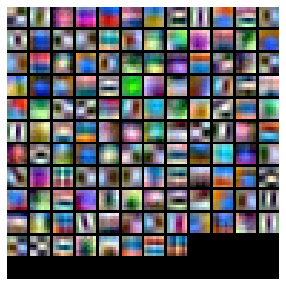

In [54]:
# You can visualize the first-layer convolutional filters from the trained network by running the following:
from utils.vis_utils import visualize_grid

grid = visualize_grid(model.params['W0'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()